## QUBO Objective Function

Objective function is defined as follows:

$$
Q(x, \alpha) = -\alpha\sum_{i=1}^{n}{I_i x_i} 
+ 
(1 - \alpha)\sum_{i, j=1}^{n}{R_{ij} x_i x_j}
$$

where $x_i$ is a binary variable, $I_i$ is the importance of the $i$-th feature, and $R_{ij}$ is the redundancy between the $i$-th and $j$-th features.

Therefore, $Q(\alpha)$ is formulated as follows:

$$
Q(\alpha)
= R_{i, j} - \alpha (R_{i, j} + \delta_{i, j}I_i)
$$

where $\delta_{i, j}$ is the Kronecker delta.

In [1]:
import pandas as pd
import numpy as np

PIC_LEN = 4
PIC_SIZE = PIC_LEN * PIC_LEN
FEATURE_SIZE = 8

In [2]:
importance = pd.read_csv('importance.csv')
redundancy = pd.read_csv('redundancy.csv')

# convert importance to 1-d array, redundancy to 2-d matrix
importance = np.array(importance).reshape(-1)
redundancy = np.array(redundancy)

In [3]:
def qubo_matrix(importance, redundancy, alpha=0.5):
    n_features = len(importance)
    qubo = np.zeros((n_features, n_features))

    for i in range(n_features):
        for j in range(n_features):
            if i == j:
                # Diagonal elements
                qubo[i][j] = redundancy[i][j] - alpha * (redundancy[i][j] + importance[i])
            else:
                # Off-diagonal elements
                qubo[i][j] = redundancy[i][j] - alpha * redundancy[i][j]

    return qubo

In [4]:
quadratic = qubo_matrix(importance, redundancy)

In [5]:
# make sure the matrix is hermitian
np.allclose(quadratic, quadratic.T)

True

### Classical Method

In [6]:
from scipy.optimize import minimize

In [7]:
# Define the objective function
def objective_function(x, Q):
    return np.dot(x, np.dot(Q, x))

In [8]:
def classical_solver(alpha):
    # initial guess
    x0 = np.zeros(len(importance))

    # Constraints: binary variables
    cons = ({'type': 'eq', 'fun': lambda x: np.mod(x, 1)})
    
    quadratic = qubo_matrix(importance, redundancy, alpha)

    # Solve the problem
    result = minimize(objective_function, x0, args=(quadratic), constraints=cons)
    return result.x

# Quantum Method

In [9]:
import numpy as np
import copy

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils.algorithm_globals import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

In [10]:
def create_problem(alpha=0.5, num_features=FEATURE_SIZE):
    mdl = Model(name='feature_selection')
    n_features = len(importance)
    x = [mdl.binary_var("x%s" % i) for i in range(len(importance))]
    
    quadratic = qubo_matrix(importance, redundancy, alpha)
    
    # Objective function: x^T Q x
    objective = mdl.sum(quadratic[i][j] * x[i] * x[j] for i in range(n_features) for j in range(n_features))
    mdl.minimize(objective)
    
    # Constraints: number of features = num_features
    mdl.add_constraint(mdl.sum(x) == num_features)
    
    qp = from_docplex_mp(mdl)
    
    return qp

In [11]:
qubo = create_problem(alpha=0.5, num_features=FEATURE_SIZE)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: feature_selection

Minimize
 obj: [ - 0.023326853838 x1^2 + 0.002025011282 x1*x2 + 0.000026167986 x1*x3
      + 0.000262612593 x1*x4 + 0.005608738872 x1*x5 + 0.001297108378 x1*x6
      + 0.000604828779 x1*x7 + 0.000773870421 x1*x8 + 0.006418256247 x1*x9
      + 0.000901344489 x1*x10 + 0.006259307669 x1*x11 + 0.000029440434 x1*x12
      + 0.007079858536 x1*x13 + 0.003052714638 x1*x14 + 0.000022895859 x1*x15
      - 0.102392534515 x2^2 + 0.000700868464 x2*x3 + 0.001071455757 x2*x4
      + 0.003052718253 x2*x5 + 0.036839533223 x2*x6 + 0.002850683347 x2*x7
      + 0.000633878802 x2*x8 + 0.038691642544 x2*x9 + 0.002508501688 x2*x10
      + 0.000711702260 x2*x11 + 0.000120105440 x2*x12 + 0.028970336712 x2*x13
      + 0.012469304649 x2*x14 + 0.000093405895 x2*x15 - 0.001139762694 x3^2
      + 0.000012259773 x3*x4 + 0.000276929720 x3*x5 + 0.001068154287 x3*x6
      + 0.000035821729 x3*x7 + 0.000009492925 x3*x8 + 0.0

In [12]:
result = CplexOptimizer().solve(qubo)
print(result.prettyprint())

objective function value: -0.25532041097688457
variable values: x0=1.0, x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=1.0, x8=0.0, x9=1.0, x10=1.0, x11=1.0, x12=0.0, x13=1.0, x14=0.0, x15=0.0
status: SUCCESS


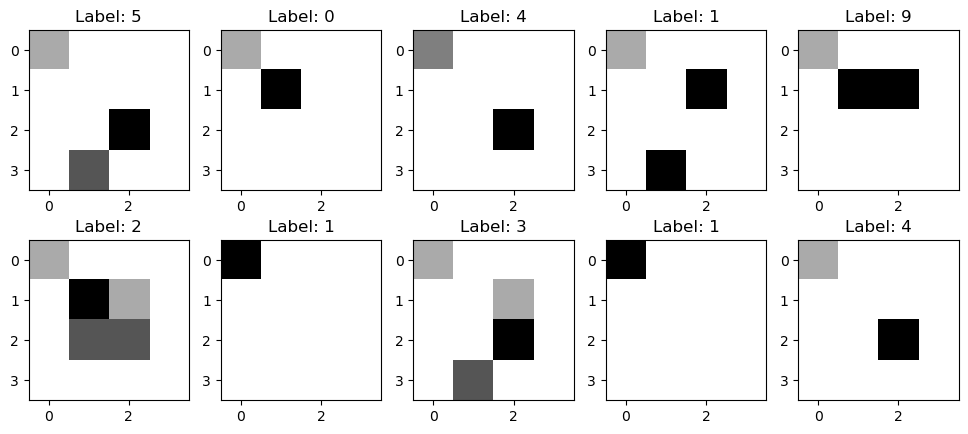

In [13]:
# convert result to feature mask
feature_mask = np.array(result.x)

# apply feature mask to data
data = pd.read_csv('mnist.csv')

# convert to image and label
image = data.drop('label', axis=1).values
label = data['label']

# apply feature mask: convert unselected features to 0
image = image * feature_mask

# display first 10 images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(image[i].reshape(PIC_LEN, PIC_LEN), cmap='binary')
    ax.set(title = f"Label: {label[i]}")

In [14]:
# drop unselected features
selected_features = np.where(feature_mask == 1)[0]
image_selected = image[:, selected_features]

In [15]:
# use svm to classify
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(image_selected, label, test_size=0.2, random_state=42)

# train svm
svm = SVC()
svm.fit(X_train, y_train)

# predict
y_pred = svm.predict(X_test)

# evaluate
accuracy_score(y_test, y_pred)

0.41064453125

In [16]:
# random feature selection
import random
random.seed(42)
random_features = random.sample(range(PIC_SIZE), FEATURE_SIZE)

# apply feature mask: convert unselected features to 0
image_random = image[:, random_features]

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(image_random, label, test_size=0.2, random_state=42)

# train svm
svm = SVC()
svm.fit(X_train, y_train)

# predict
y_pred = svm.predict(X_test)

# evaluate
accuracy_score(y_test, y_pred)

0.1474609375

## Solving QUBO using Quantum Circuit

In [17]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

In [18]:
qubo = QuadraticProgram()

# add PIC_SIZE binary variables
for i in range(PIC_SIZE):
    qubo.binary_var(f'x_{i}')

# add objective function: minimize x^T Q x
qubo_m = qubo_matrix(importance, redundancy, alpha=0.5)

# minimize x^T Q x
qubo.minimize(
    linear=[0] * PIC_SIZE,
    quadratic=qubo_m,
)

# constraint: number of features = FEATURE_SIZE
qubo.linear_constraint(
    linear=[1] * PIC_SIZE,
    sense='==',
    rhs=FEATURE_SIZE,
)

<LinearConstraint: x_0 + x_1 + x_10 + x_11 + x_12 + x_13 + x_14 + x_1... == 8 'c0'>

In [19]:
op, offset = QuadraticProgramToQubo().convert(qubo).to_ising()

In [20]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)

In [21]:
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 24.056403116659 x0 - 24.068066543578 x1 - 24.107599383917 x2
      - 24.056972998006 x3 - 24.062750921296 x4 - 24.142451623271 x5
      - 24.105696191149 x6 - 24.066919568499 x7 - 24.059441805270 x8
      - 24.134811833462 x9 - 24.099424158748 x10 - 24.068108745753 x11
      - 24.057181690201 x12 - 24.089569468751 x13 - 24.077023639377 x14
      - 24.057008038350 x15 + [ 6.415040831109 x0*x1 + 6.415040831109 x0*x2
      + 6.415040831109 x0*x3 + 6.415040831109 x0*x4 + 6.415040831109 x0*x5
      + 6.415040831109 x0*x6 + 6.415040831109 x0*x7 + 6.415040831109 x0*x8
      + 6.415040831109 x0*x9 + 6.415040831109 x0*x10 + 6.415040831109 x0*x11
      + 6.415040831109 x0*x12 + 6.415040831109 x0*x13 + 6.415040831109 x0*x14
      + 6.415040831109 x0*x15 + 6.417065842391 x1*x2 + 6.415066999095 x1*x3
      + 6.415303443702 x1*x4 + 6.420649569981 x1*x5 + 6.416337939487 x1*x6
      + 6.415645659888 

In [22]:
algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

In [23]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes) # using exact classical eigensolver

In [24]:
qaoa_result = qaoa.solve(qp)

In [25]:
exact_result = exact.solve(qp)

In [26]:
# convert result to feature mask
feature_mask = np.array(qaoa_result.x)

In [27]:
# apply feature mask to data, drop unselected features
selected_features = np.where(feature_mask == 1)[0]
image_selected = image[:, selected_features]

In [28]:
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(image_selected, label, test_size=0.2, random_state=42)

# print data shape
print(f"X_train: {X_train.shape}")

# train svm
svm = SVC()
svm.fit(X_train, y_train)

# predict
y_pred = svm.predict(X_test)

# evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

X_train: (8192, 8)
Accuracy: 0.41064453125


In [29]:
# train with original data
X_train, X_test, y_train, y_test = train_test_split(image, label, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}")

# train svm
svm = SVC()
svm.fit(X_train, y_train)

# predict
y_pred = svm.predict(X_test)

# evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

X_train: (8192, 16)
Accuracy: 0.40625


## IBM Simulator

In [30]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qubo = create_problem(alpha=0.5, num_features=FEATURE_SIZE)
qubo = QuadraticProgramToQubo().convert(qubo)

In [31]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

In [32]:
service = QiskitRuntimeService(channel='ibm_cloud')

In [33]:
backend=service.backend(name='ibmq_qasm_simulator')

In [34]:
hamiltonian = qubo.to_ising()[0]

In [35]:
ansatz = QAOAAnsatz(hamiltonian, reps=2)

In [36]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [37]:
options = Options()
options.execution.shots = 10000

session = Session(backend=backend)

estimator = Estimator(session=session, backend=backend, options=options)
sampler = Sampler(session=session, backend=backend, options=options)

In [38]:
# initial parameters
x0 = np.zeros(ansatz.num_parameters)

In [39]:
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method='COBYLA',
)

In [40]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.652439114509998
       x: [-1.057e-01  3.148e-01 -1.494e-01  2.446e-02]
    nfev: 53
   maxcv: 0.0

In [41]:
qc = ansatz.assign_parameters(res.x)

In [42]:
qc.measure_all()

In [43]:
samp_dist = sampler.run(qc).result().quasi_dists[0]

In [44]:
sampler.run(qc).result()

SamplerResult(quasi_dists=[{21037: 0.0001, 32771: 0.0001, 3765: 0.0001, 30771: 0.0001, 11625: 0.0001, 60080: 0.0001, 30246: 0.0001, 14044: 0.0001, 23150: 0.0001, 54407: 0.0001, 58288: 0.0001, 6581: 0.0001, 45404: 0.0001, 10710: 0.0001, 29443: 0.0001, 50012: 0.0001, 46359: 0.0001, 25277: 0.0001, 23175: 0.0001, 3917: 0.0001, 15017: 0.0001, 13430: 0.0001, 60810: 0.0001, 13234: 0.0001, 61096: 0.0001, 4683: 0.0001, 54628: 0.0001, 29127: 0.0001, 36804: 0.0001, 37779: 0.0001, 8591: 0.0001, 7657: 0.0001, 1878: 0.0001, 31001: 0.0001, 42648: 0.0001, 37966: 0.0001, 18909: 0.0001, 54608: 0.0001, 33769: 0.0001, 22504: 0.0002, 37609: 0.0001, 1183: 0.0001, 49945: 0.0001, 14114: 0.0001, 1743: 0.0001, 41051: 0.0001, 49387: 0.0001, 52456: 0.0001, 47389: 0.0001, 28060: 0.0001, 5477: 0.0001, 26254: 0.0001, 32129: 0.0001, 24795: 0.0001, 22328: 0.0001, 41433: 0.0001, 9701: 0.0001, 32895: 0.0001, 27809: 0.0001, 59420: 0.0001, 43618: 0.0001, 22586: 0.0001, 59715: 0.0002, 53819: 0.0001, 35228: 0.0001, 42481: 0

In [45]:
binary_probs = samp_dist.binary_probabilities()

In [46]:
df_binary_probs = pd.DataFrame(binary_probs.items(), columns=['bitstring', 'probability'])

In [47]:
# rank by probability
df_binary_probs.sort_values(by=['probability'], ascending=False, inplace=True)

In [48]:
# save to csv
df_binary_probs.to_csv('binary_probs_simulator.csv', index=False)

In [49]:
# take the first row, convert bitstring to feature mask
feature_mask = np.array([int(x) for x in df_binary_probs.iloc[0]['bitstring']])

# apply feature mask to data, drop unselected features
selected_features = np.where(feature_mask == 1)[0]
image_selected = image[:, selected_features]

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(image_selected, label, test_size=0.2, random_state=44)

# print data shape
print(f"X_train: {X_train.shape}")

# train svm
svm = SVC()
svm.fit(X_train, y_train)

# predict
y_pred = svm.predict(X_test)

# evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

X_train: (8192, 9)
Accuracy: 0.31982421875
